In [3]:
'''
GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints
(https://arxiv.org/pdf/2305.13245)

The TLDR of GQA vs normal MHSA is that storing lots of keys and values for many heads 
takes up a lot of memory, so we just share keys and values across multiple heads, grouping
the keys/vals for a layer by the queries (which we keep one set of per head)
so the MHSA is now "grouped" and less expensive, especially for longer sequences
when the memory required to store lots of keys and values (see KV cache) grows large. 
'''
import torch 
import torch.nn as nn 
import torch.nn.functional as F


In [4]:
# Here's MHSA baseline we'll compare GQA to, to check its speedup as a function of seqlen 
# Note. torch.einsum is confusing notationally when you first see it, but is one of the most fundamental and widely
# used operations, generalizing matrix multiplication greatly, and it becomes very fast and intuitive to do 
# many operations at once when you get used to it. I highly recommend reading the docs and playing around 
# with some examples to get the hang of it. 
class mhsa(nn.Module): 
    def __init__(self, D=512, head_dim=64, causal=True): 
        super().__init__()
        self.D = D 
        self.head_dim = head_dim 
        assert self.D % self.head_dim == 0 
        self.nheads = self.D // self.head_dim 
        self.causal = causal 

        self.wq = nn.Linear(D, D)
        self.wk = nn.Linear(D, D)
        self.wv = nn.Linear(D, D)
        self.wo = nn.Linear(D, D)


    def forward(self, x): # BSD -> BSD
        B, S, D = x.shape
        q, k, v = self.wq(x), self.wk(x), self.wv(x) # x is BSD wq is DD

        q = q.reshape(B, self.nheads, S, self.head_dim)
        k = k.reshape(B, self.nheads, S, self.head_dim)
        v = v.reshape(B, self.nheads, S, self.head_dim) 

        normalize = torch.sqrt(torch.tensor(self.head_dim))
        A = torch.einsum('bnij,bnkj->bnik', q, k) # [B, N, S, D] @ [B, N, S, D] -> [B, N, S, S]
        A = nn.functional.softmax(A/normalize, dim=-1)

        # check if causal mask 
        if self.causal: # add -inf in A[j>i], because we don't want to attend to future tokens to mimic inference time 
            mask = torch.triu(torch.ones_like(A), diagonal=1).bool()
            A = A.masked_fill(mask, float('-inf'))

        preout = torch.einsum('bnij,bnjd->bnid', A, v) # BNSS @ BNSD -> BNSD
        preout = preout.reshape(B, S, -1) # this concats the head outputs under the hood 
        return self.wo(preout)

B, S, D = 8, 512, 768
attn = mhsa(D=D) 
x = torch.randn(B, S, D)
attn(x).shape # BSD -> BSD 


torch.Size([8, 512, 768])

In [5]:
import numpy as np 

class GQA(torch.nn.Module): 
    def __init__(self, D=512, head_dim=64, causal=True, group_size=4): 
        super().__init__()
        self.D = D 
        self.head_dim = head_dim 
        assert self.D % self.head_dim == 0 
        self.num_query_heads = self.D // self.head_dim 
        self.group_size = group_size
        # In GQA, keys and values use fewer heads: 
        # each group of query heads will share a common key/value, so:
        self.num_kv_heads = self.num_query_heads // self.group_size 
        self.causal = causal

        self.D_kv = self.num_kv_heads * self.head_dim

        self.wq = torch.nn.Linear(D, D)
        self.wk = torch.nn.Linear(D, self.D_kv)
        self.wv = torch.nn.Linear(D, self.D_kv)
        self.wo = torch.nn.Linear(D, D)


    def forward(self, x):  # Input x: [B, S, D] -> Output: [B, S, D]
        B, S, D = x.shape
        q = self.wq(x)  # [B, S, D]
        k = self.wk(x)  # [B, S, D_kv]
        v = self.wv(x)  # [B, S, D_kv]

        # Reshape queries to have all query heads.
        q = q.reshape(B, self.num_query_heads, S, self.head_dim)
        k = k.reshape(B, self.num_kv_heads, S, self.head_dim)
        v = v.reshape(B, self.num_kv_heads, S, self.head_dim)

        # reshape kv to match q by interleaving
        k = torch.repeat_interleave(k, self.group_size, dim=1)
        v = torch.repeat_interleave(v, self.group_size, dim=1)

        # Compute scaled dot-product attention.
        normalize = torch.sqrt(torch.tensor(self.head_dim, dtype=q.dtype, device=q.device))
        logits = torch.einsum('bnij,bnkj->bnik', q, k) / normalize  # [B, num_query_heads, S, S]

        # Apply causal mask if needed.
        if self.causal:
            mask = torch.triu(torch.ones_like(logits), diagonal=1).bool()
            logits = logits.masked_fill(mask, float('-inf'))

        A = torch.nn.functional.softmax(logits, dim=-1)
        preout = torch.einsum('bnij,bnjd->bnid', A, v)  # [B, num_query_heads, S, head_dim]
        preout = preout.reshape(B, S, -1)  # Concatenate heads: [B, S, D]
        return self.wo(preout)



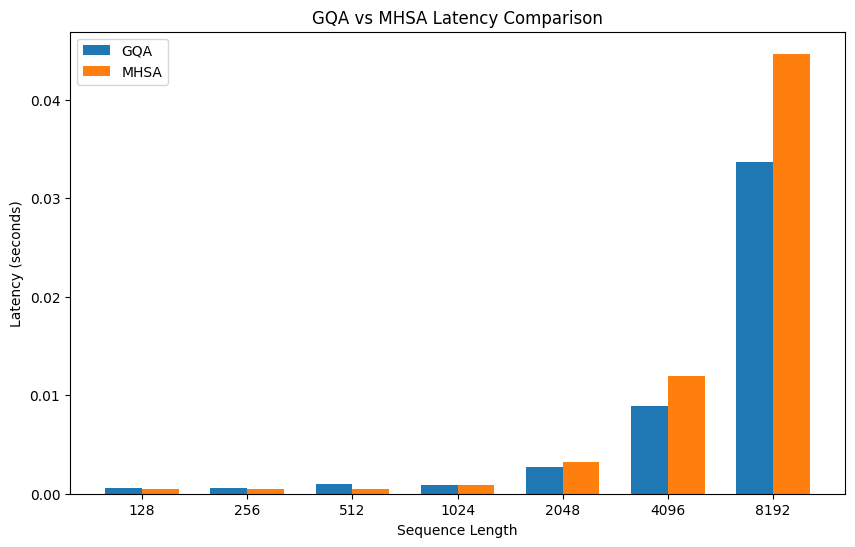

In [6]:
import matplotlib.pyplot as plt
import time

# profile relative latencies for different sequence lengths
seq_lengths = [128, 256, 512, 1024, 2048, 4096, 8192]
B, D = 1, 1024  # keep B, D fixed for now and vary S

gqa_times = []
mhsa_times = []

for S in seq_lengths:
    x = torch.randn(B, S, D, device='cuda')
    
    
    attn_gqa = GQA(D=D).cuda()
    
    # warmup
    for _ in range(5):
        _ = attn_gqa(x)
    
    start = time.perf_counter()
    for _ in range(10):
        _ = attn_gqa(x)
    torch.cuda.synchronize()
    gqa_times.append((time.perf_counter() - start) / 10)

    attn_mhsa = mhsa(D=D).cuda()
    
    # warmup
    for _ in range(5):
        _ = attn_mhsa(x)
    
    # profile MHSA
    start = time.perf_counter()
    for _ in range(10):
        _ = attn_mhsa(x)
    torch.cuda.synchronize()
    mhsa_times.append((time.perf_counter() - start) / 10)

# plot empirical speedup of GQA vs MHSA, as expected it does better for longer sequences
# when storing lots of K/V for all the heads would be memory-expensive and thus 
# reduce the amount of memory we have available to speed up computation 
x = np.arange(len(seq_lengths))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, gqa_times, width, label='GQA')
ax.bar(x + width/2, mhsa_times, width, label='MHSA')

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sequence Length')
ax.set_title('GQA vs MHSA Latency Comparison')
ax.set_xticks(x)
ax.set_xticklabels(seq_lengths)
ax.legend()

# one of the most satisfying plots in this codebase IMO!
plt.show()
